### Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.lines import Line2D
%config InlineBackend.figure_format='retina'

# CERN modules
import fillingpatterns as fp

# Improve style
sns.set_theme(style="whitegrid")


### Load filling scheme and analyse beam-beam schedule with FillingPatterns

In [2]:
# Load filling scheme
fname = "../master_jobs/filling_scheme/8b4e_1972b_1960_1178_1886_224bpi_12inj_800ns_bs200ns.json"
patt = fp.FillingPattern.from_json(fname)


Computing collision schedules...
Done Beam 1
Done Beam 2


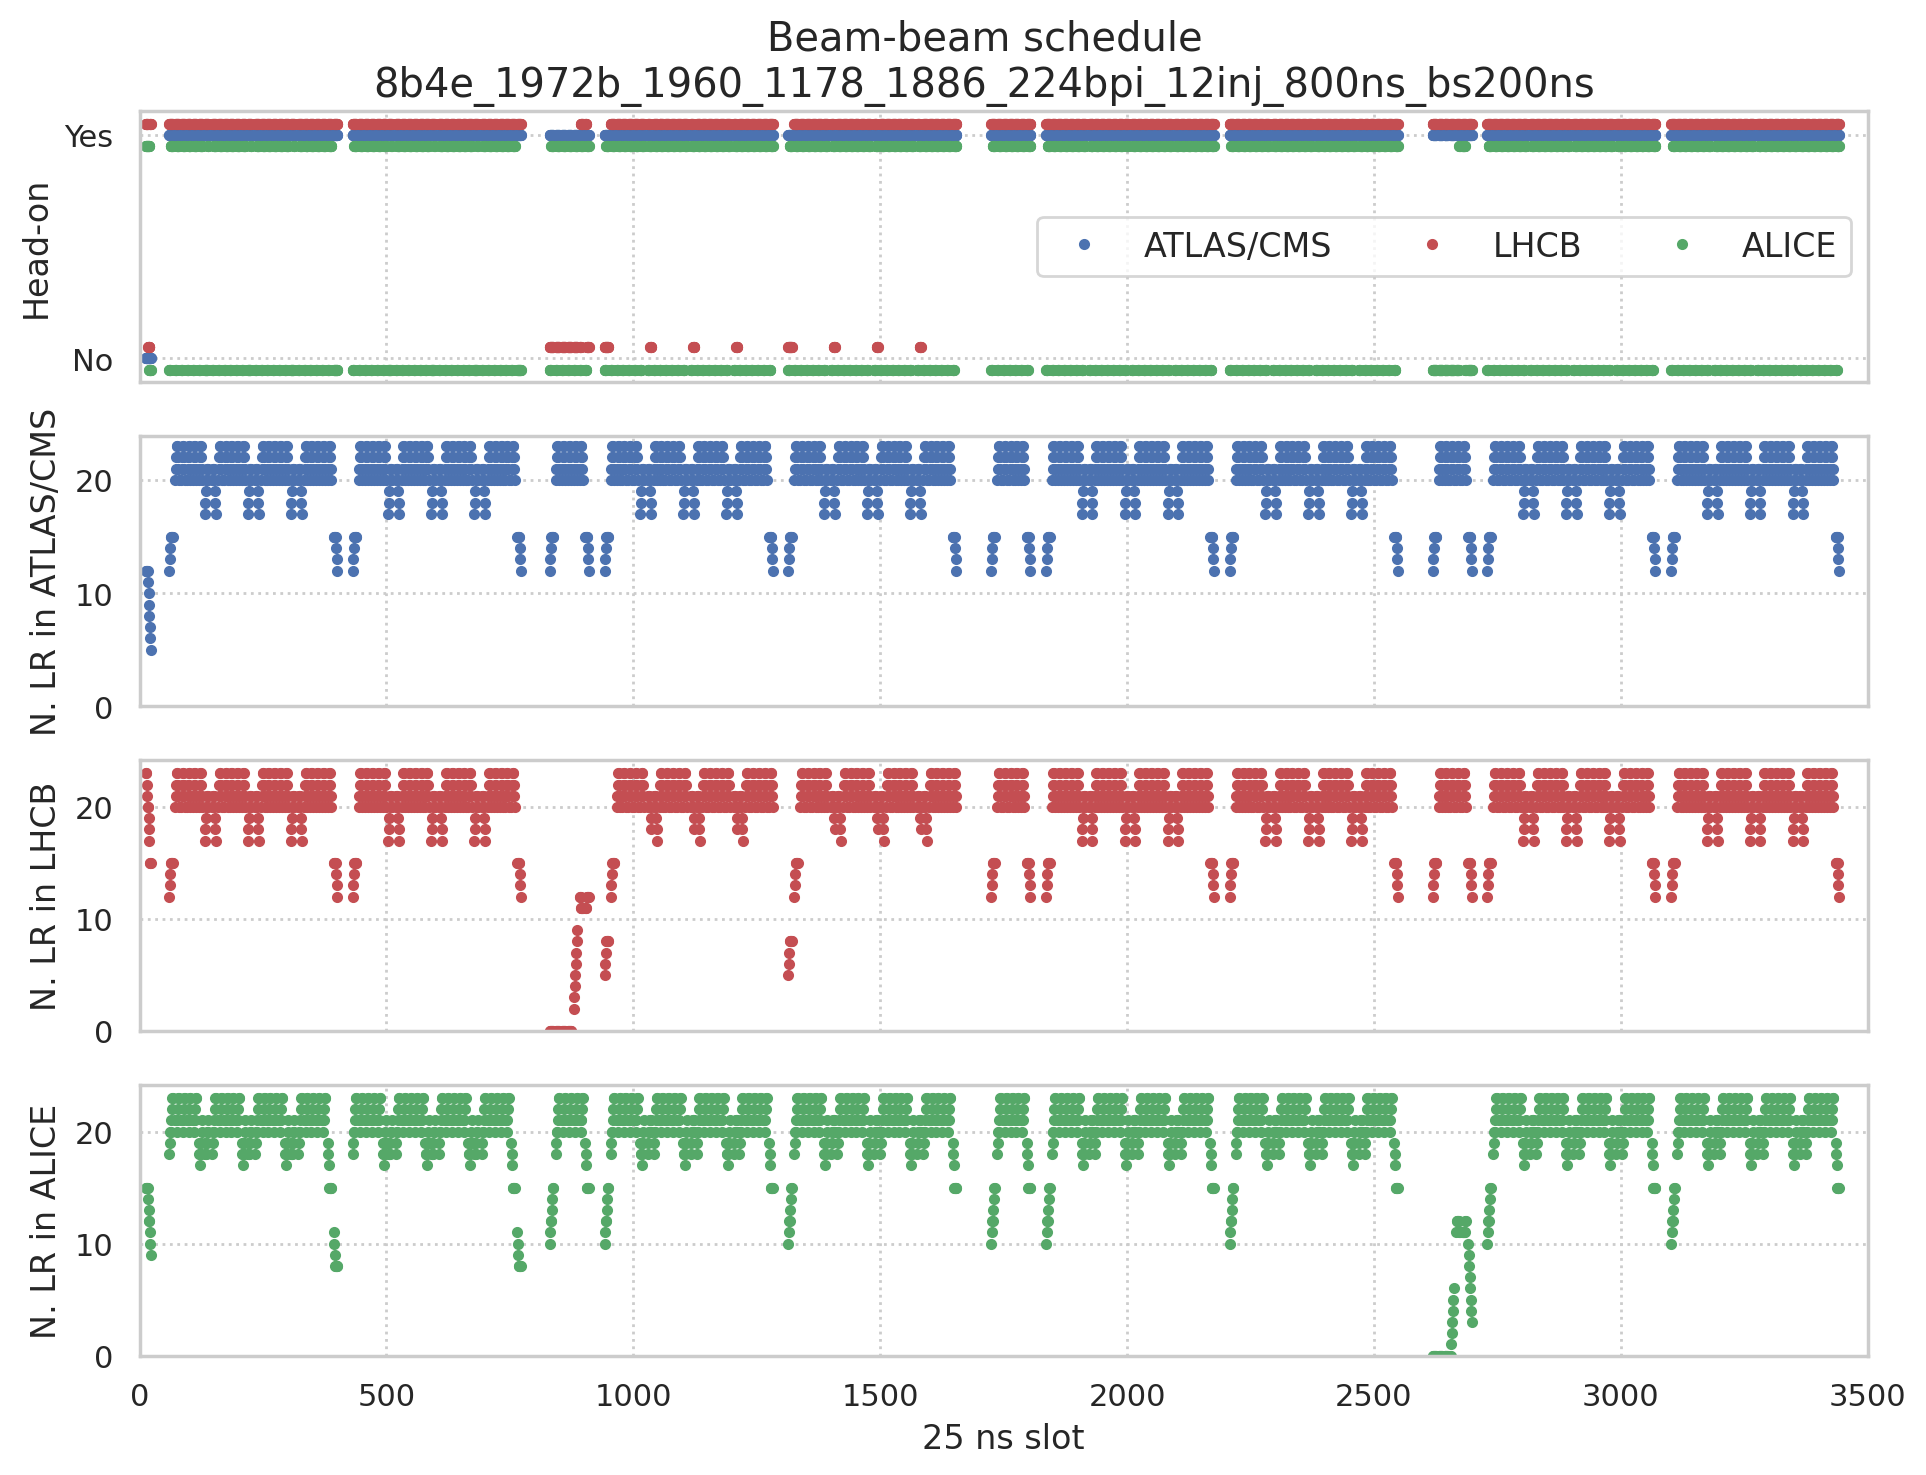

In [3]:
# Compute bb schedule
patt.compute_beam_beam_schedule(n_lr_per_side=16)

# Plot bb-schedule for beam 1
bbs = patt.b1.bb_schedule

fig1 = plt.figure(100, figsize=(6.4 * 1.5, 1.6 * 4.8))
ax1 = fig1.add_subplot(4, 1, 1)
ax2 = fig1.add_subplot(4, 1, 2, sharex=ax1)
ax3 = fig1.add_subplot(4, 1, 3, sharex=ax1)
ax4 = fig1.add_subplot(4, 1, 4, sharex=ax1)

ax1.plot(bbs["collides in ATLAS/CMS"], ".", color="b", label="ATLAS/CMS")
ax1.plot(0.05 + bbs["collides in LHCB"], ".", color="r", label="LHCB")
ax1.plot(-0.05 + bbs["collides in ALICE"], ".", color="g", label="ALICE")
ax1.legend(ncol=3, loc="center right", fontsize="medium")

ax1.plot(bbs["collides in ATLAS/CMS"], ".", color="b")
ax1.plot(0.05 + bbs["collides in LHCB"], ".", color="r")
ax1.plot(-0.05 + bbs["collides in ALICE"], ".", color="g")

ax2.plot(bbs["# of LR in ATLAS/CMS"], ".", color="b")
ax3.plot(bbs["# of LR in LHCB"], ".", color="r")
ax4.plot(bbs["# of LR in ALICE"], ".", color="g")

ax1.set_ylabel("Head-on")
ax2.set_ylabel("N. LR in ATLAS/CMS")
ax3.set_ylabel("N. LR in LHCB")
ax4.set_ylabel("N. LR in ALICE")

ax1.set_yticks([0, 1])
ax1.set_yticklabels(["No", "Yes"])
ax4.set_xlim(0, 3500)
ax4.set_xlabel("25 ns slot")

for aa in [ax1, ax2, ax3]:
    aa.tick_params(labelbottom=False)

for aa in [ax1, ax2, ax3, ax4]:
    aa.grid(True, linestyle=":")

for aa in [ax2, ax3, ax4]:
    aa.set_ylim(bottom=0)

fig1.subplots_adjust(left=0.06, right=0.96, top=0.92)
fig1.suptitle("Beam-beam schedule\n" + patt.scheme_name.split("/filling_scheme/")[1])
plt.show()


### Cluster the bunches according to their interaction pattern

First project variance in a lower-dimensional space with a non-linear methods (t-SNE or UMAP).

There are 6 coordinates contained in the bbs dataframe:
 1. collides in ATLAS/CMS
 2. collides in LHCB
 3. collides in ALICE
 4. nb of LR in ATLAS/CMS
 5. nb of LR in LHCB
 6. nb of LR in ALICE

These will be projected in a 2D space

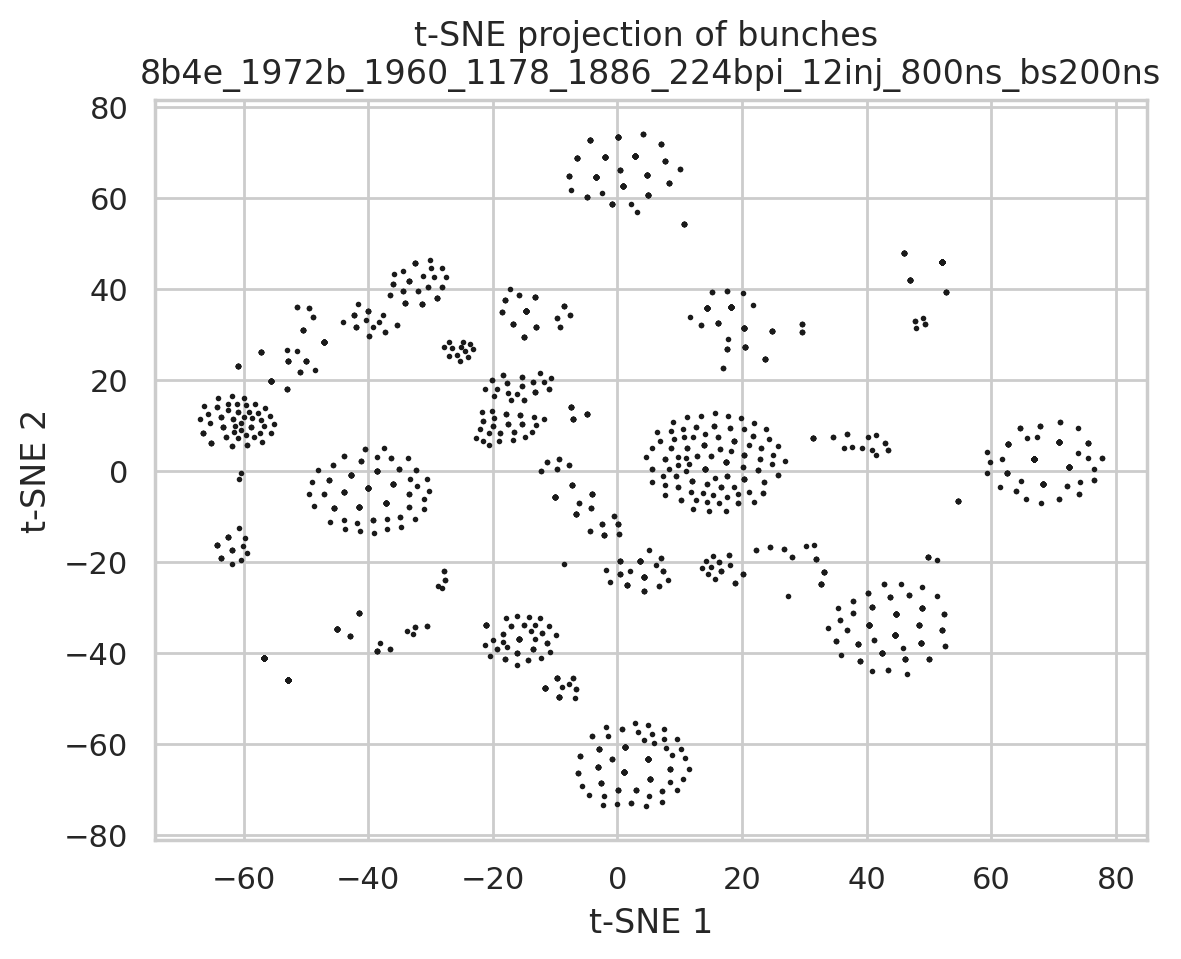

In [4]:
# Project bunches in 2D using t-sne
bbs = patt.b1.bb_schedule
array_bunches = np.array(
    [
        bbs["collides in ATLAS/CMS"],
        bbs["collides in LHCB"],
        bbs["collides in ALICE"],
        bbs["# of LR in ATLAS/CMS"],
        bbs["# of LR in LHCB"],
        bbs["# of LR in ALICE"],
    ],
    dtype=np.float32,
).T

# Add some noise to the data to prevent matrix singularity (with umap)
# array_bunches += np.random.normal(0, 0.001, array_bunches.shape)

# Rescale data to have unit variance
scaled_array_bunches = StandardScaler().fit_transform(array_bunches)

# Compute t-SNE projection
tsne = manifold.TSNE(
    n_components=2, perplexity=80, early_exaggeration=150, random_state=1, metric="manhattan"
)
array_bunches_2d = tsne.fit_transform(scaled_array_bunches)

# Plot tsne projection
fig = plt.figure()
plt.scatter(array_bunches_2d[:, 0], array_bunches_2d[:, 1], s=1, c="k")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("t-SNE projection of bunches \n" + patt.scheme_name.split("/filling_scheme/")[1])
plt.show()


Then cluster using Gaussian mixtures models or K-means. Elbow method or bayesian information criterium didn't work well, so the number of cluster was chosen 'by eye'. Random state also had to be optimized.

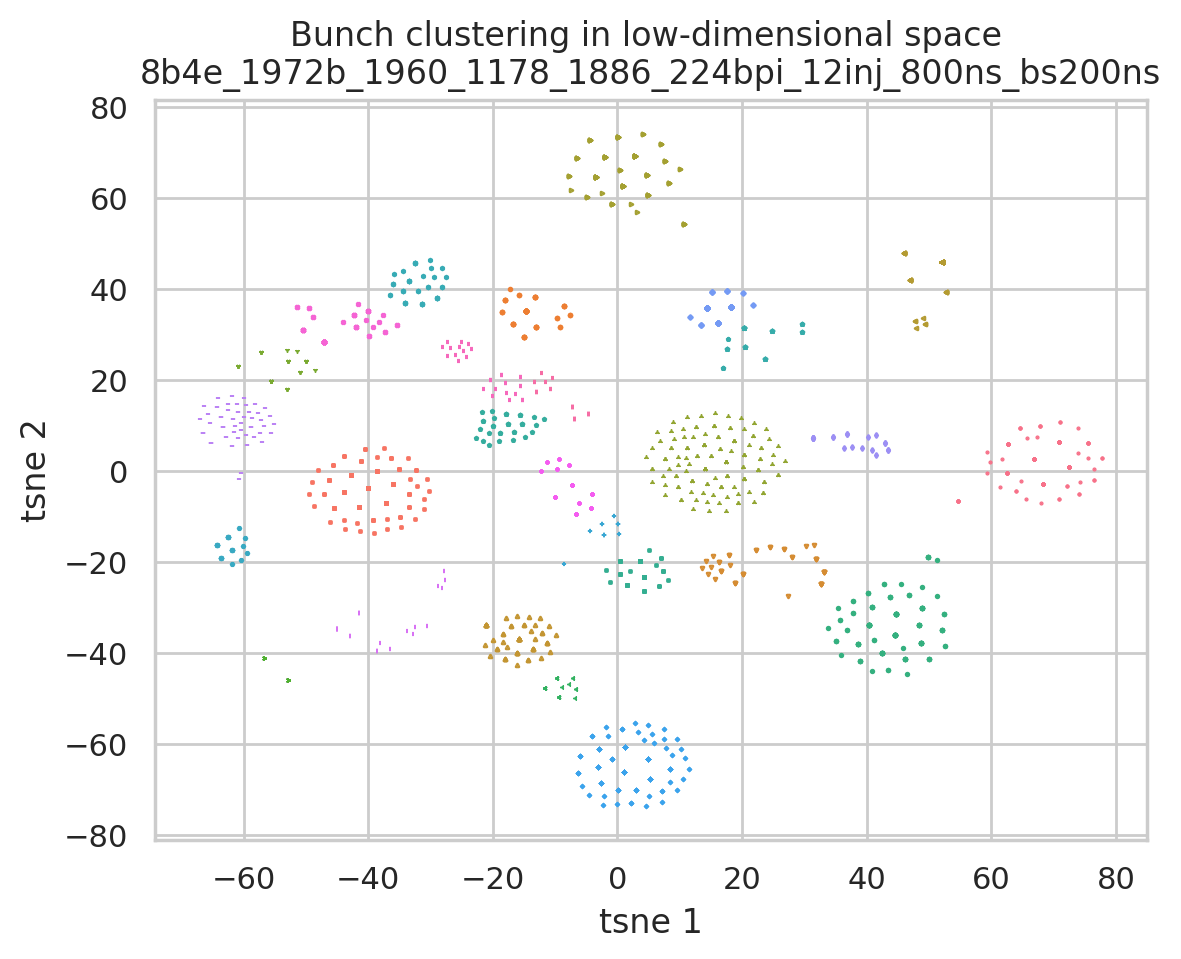

In [5]:
# Cluster the bunches in 27 clusters
n_clusters = 27
# kmeans = GaussianMixture(n_clusters=n_clusters, random_state=random_state).fit(array_bunches_2d)
gm_clusters = GaussianMixture(n_components=n_clusters, random_state=48, covariance_type="full").fit(
    array_bunches_2d
)
# bunches_labels = kmeans.labels_
bunches_labels = gm_clusters.predict(array_bunches_2d)
color_list = sns.color_palette("husl", n_clusters)
marker_list = list(Line2D.markers.keys())
# Plot the clusters in 2D
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(n_clusters):
    ax.scatter(
        array_bunches_2d[bunches_labels == i, 0],
        array_bunches_2d[bunches_labels == i, 1],
        label=f"cluster {i}",
        color=color_list[i],
        s=1,
        marker=marker_list[i],
    )
ax.set_xlabel("tsne 1")
ax.set_ylabel("tsne 2")
ax.set_title(
    "Bunch clustering in low-dimensional space \n" + patt.scheme_name.split("/filling_scheme/")[1]
)
plt.show()


For each cluster, find the centroid and the corresponding closest bunch.

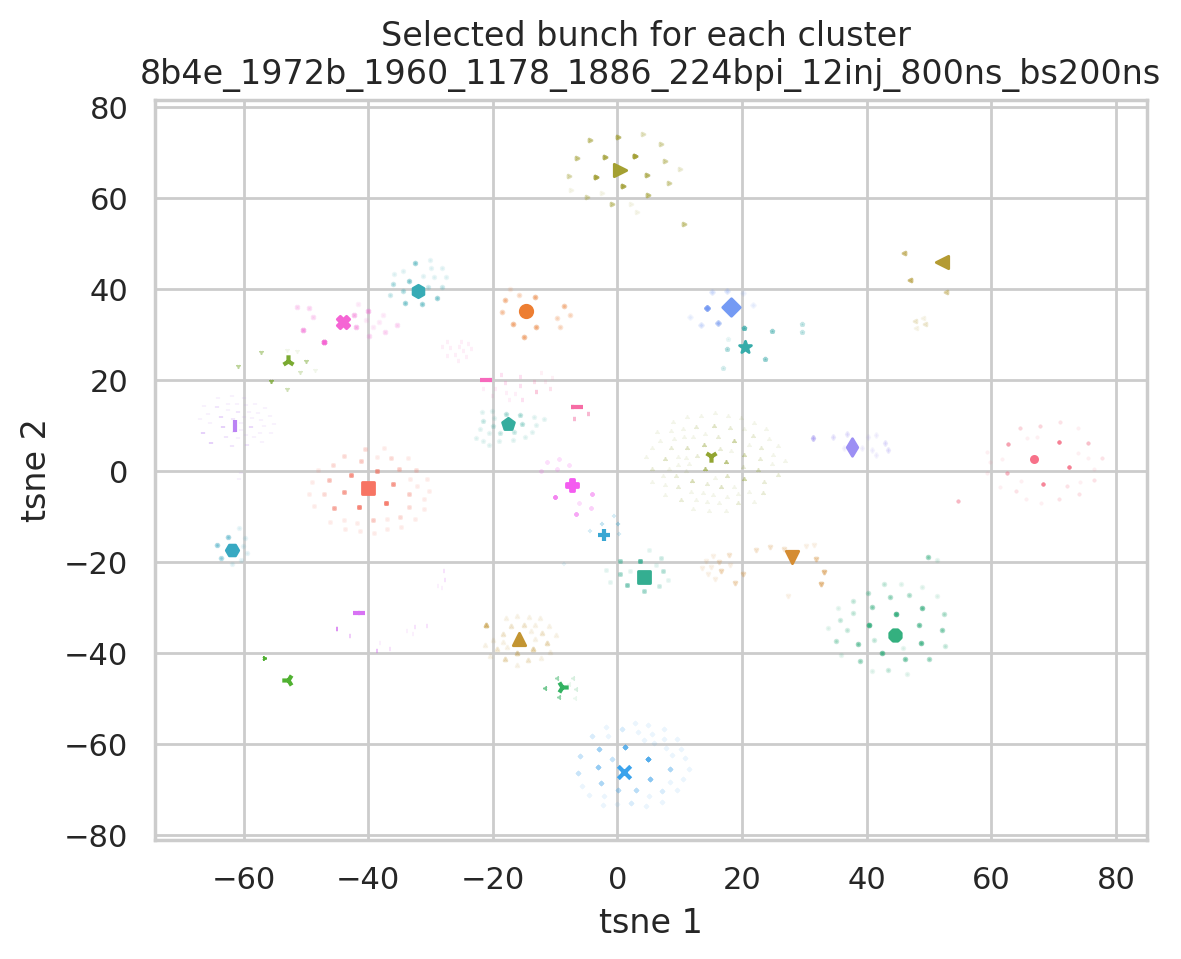

In [6]:
# Get the index of the point closest to the centroid of each cluster (using bunches_labels)
l_idx = []
for i in range(n_clusters):
    centroid = np.mean(array_bunches_2d[bunches_labels == i], axis=0)
    dist = np.sqrt(
        (array_bunches_2d[bunches_labels == i, 0] - centroid[0]) ** 2
        + (array_bunches_2d[bunches_labels == i, 1] - centroid[1]) ** 2
    )
    l_idx.append(np.argmin(dist))

# # Plot all the bunches along with the bunches selected in the previous step (in 2D)
fig = plt.figure()
ax = fig.add_subplot(111)
for i in range(n_clusters):
    ax.scatter(
        array_bunches_2d[bunches_labels == i, 0],
        array_bunches_2d[bunches_labels == i, 1],
        label=f"cluster {i}",
        color=color_list[i],
        s=1,
        marker=marker_list[i],
        alpha=0.1,
    )
    ax.scatter(
        array_bunches_2d[bunches_labels == i, 0][l_idx[i]],
        array_bunches_2d[bunches_labels == i, 1][l_idx[i]],
        label=f"cluster {i}",
        color=color_list[i],
        s=20,
        marker=marker_list[i],
    )
# ax.legend()
ax.set_xlabel("tsne 1")
ax.set_ylabel("tsne 2")
ax.set_title("Selected bunch for each cluster \n" + patt.scheme_name.split("/filling_scheme/")[1])
plt.show()


In [7]:
# Get the bunches corresponding to the index (keeping only the first one, as many bunches are identical)
l_bunches = []
for i in range(n_clusters):
    # Get index in array_bunches_2d first
    array_cluster = array_bunches_2d[bunches_labels == i]

    # Get the list of clusters corresponding to the central bunch
    l_idx_centroids = np.where(
        (array_bunches_2d[:, 0] == array_cluster[l_idx[i]][0])
        & (array_bunches_2d[:, 1] == array_cluster[l_idx[i]][1])
    )[0]

    # Only keep one (they're all identical)
    idx = l_idx_centroids[0]

    # Add the corresponding index from the dataframe
    l_bunches.append(bbs.index[idx])

print("List of selected bunches: ", l_bunches)


List of selected bunches:  [76, 2754, 1731, 2682, 607, 77, 3342, 2053, 2803, 74, 1403, 2049, 139, 848, 1912, 398, 2633, 2300, 2854, 126, 897, 222, 1043, 154, 3435, 942, 1036]


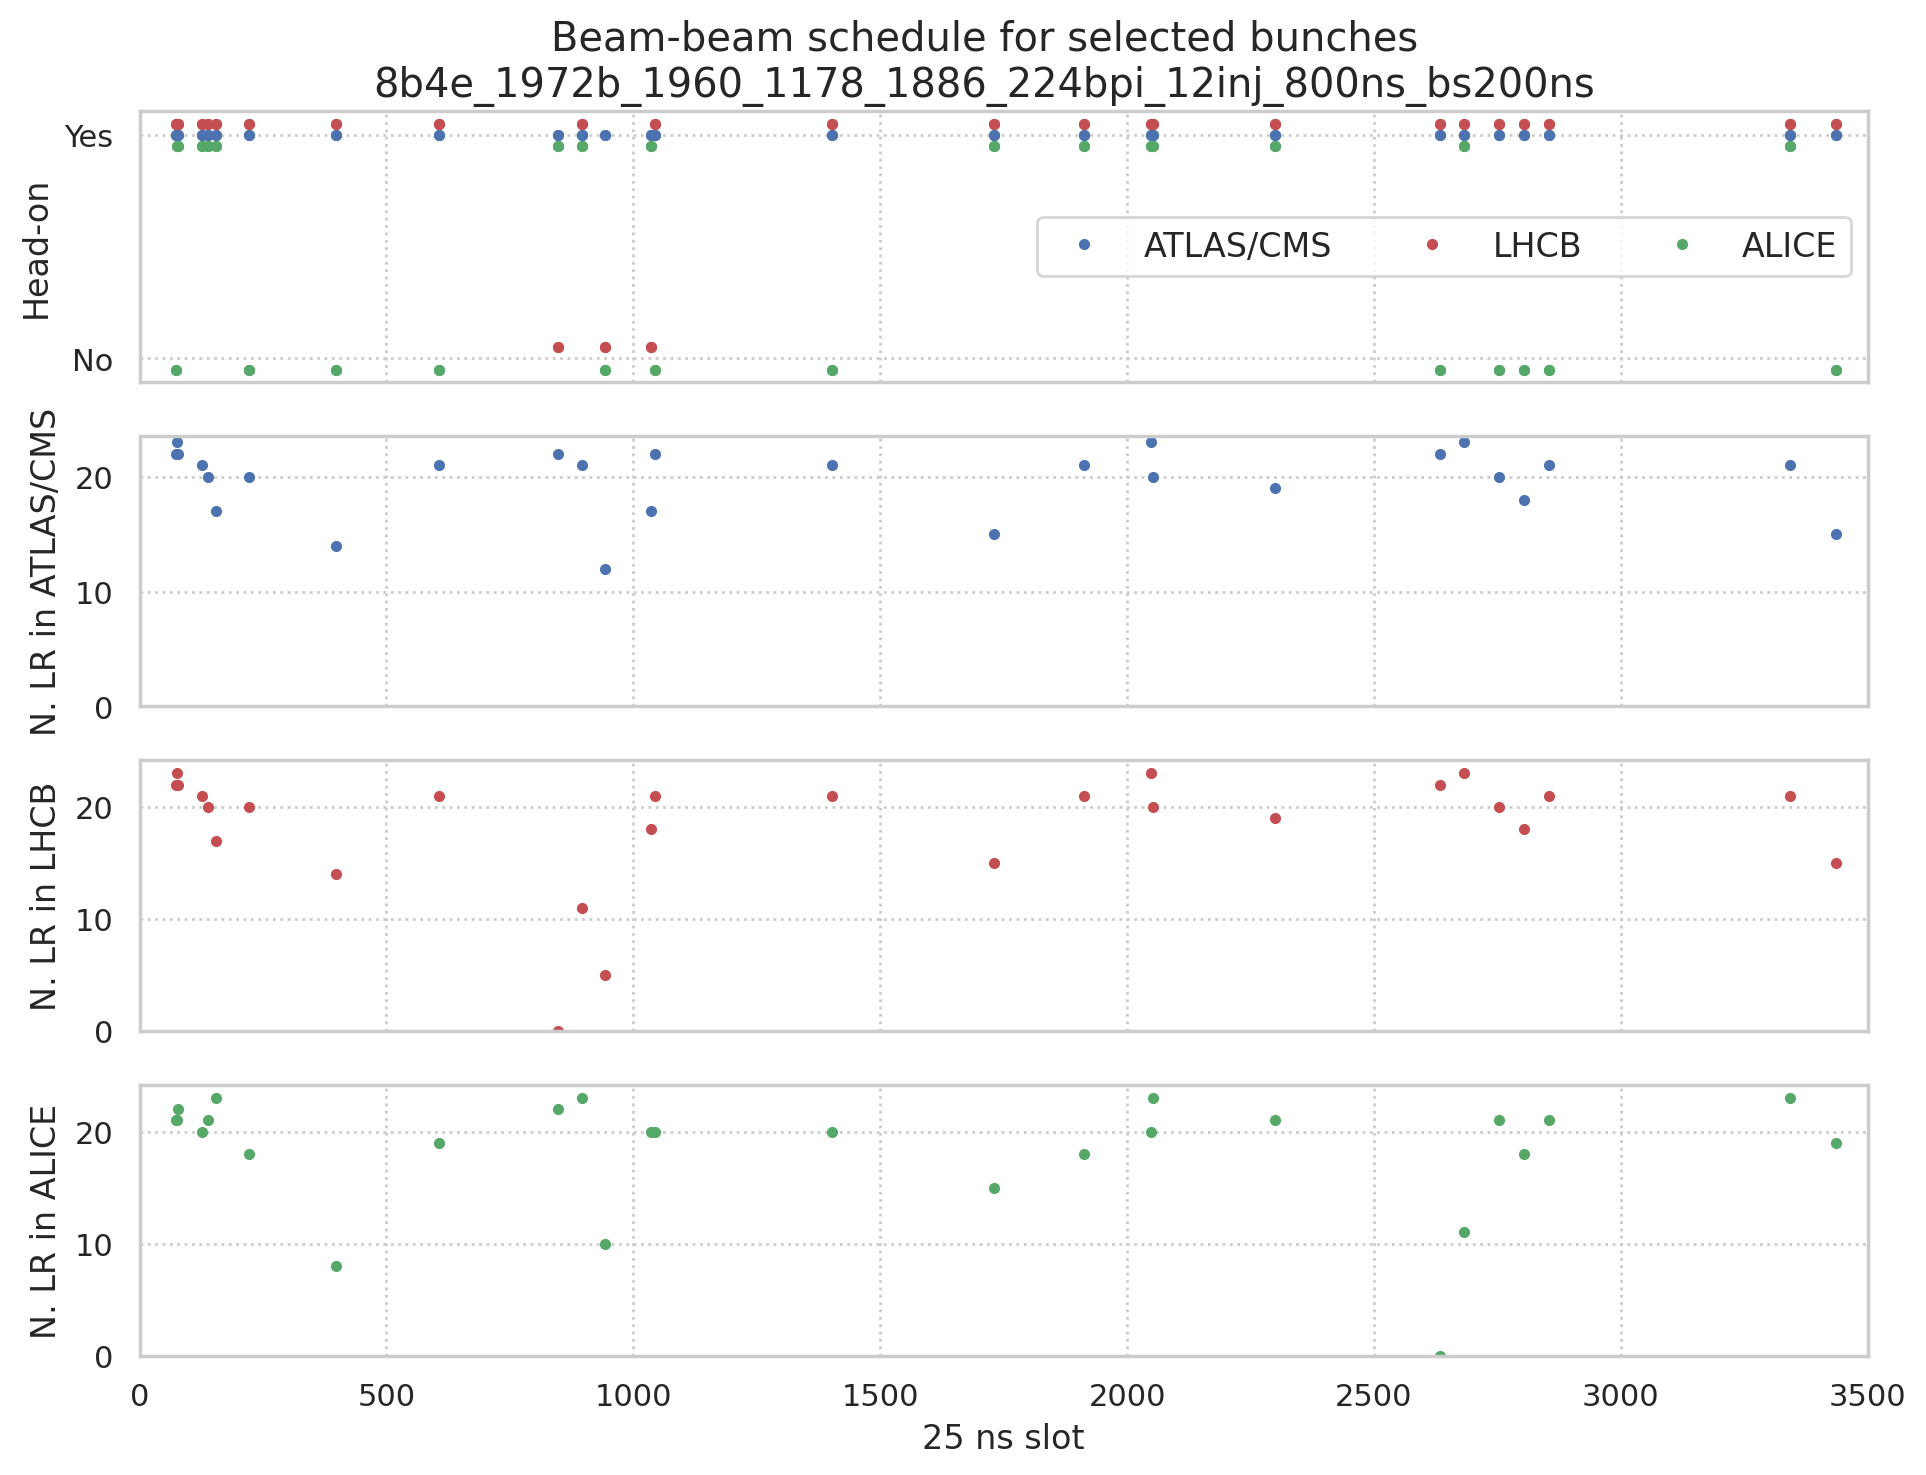

In [8]:
# Plot the interactions of the selected bunches
fig1 = plt.figure(100, figsize=(6.4 * 1.5, 1.6 * 4.8))
ax1 = fig1.add_subplot(4, 1, 1)
ax2 = fig1.add_subplot(4, 1, 2, sharex=ax1)
ax3 = fig1.add_subplot(4, 1, 3, sharex=ax1)
ax4 = fig1.add_subplot(4, 1, 4, sharex=ax1)

ax1.plot(bbs["collides in ATLAS/CMS"][l_bunches], ".", color="b", label="ATLAS/CMS")
ax1.plot(0.05 + bbs["collides in LHCB"][l_bunches], ".", color="r", label="LHCB")
ax1.plot(-0.05 + bbs["collides in ALICE"][l_bunches], ".", color="g", label="ALICE")
ax1.legend(ncol=3, loc="center right", fontsize="medium")

ax1.plot(bbs["collides in ATLAS/CMS"][l_bunches], ".", color="b")
ax1.plot(0.05 + bbs["collides in LHCB"][l_bunches], ".", color="r")
ax1.plot(-0.05 + bbs["collides in ALICE"][l_bunches], ".", color="g")

ax2.plot(bbs["# of LR in ATLAS/CMS"][l_bunches], ".", color="b")
ax3.plot(bbs["# of LR in LHCB"][l_bunches], ".", color="r")
ax4.plot(bbs["# of LR in ALICE"][l_bunches], ".", color="g")

ax1.set_ylabel("Head-on")
ax2.set_ylabel("N. LR in ATLAS/CMS")
ax3.set_ylabel("N. LR in LHCB")
ax4.set_ylabel("N. LR in ALICE")

ax1.set_yticks([0, 1])
ax1.set_yticklabels(["No", "Yes"])
ax4.set_xlim(0, 3500)
ax4.set_xlabel("25 ns slot")

for aa in [ax1, ax2, ax3]:
    aa.tick_params(labelbottom=False)

for aa in [ax1, ax2, ax3, ax4]:
    aa.grid(True, linestyle=":")

for aa in [ax2, ax3, ax4]:
    aa.set_ylim(bottom=0)

fig1.subplots_adjust(left=0.06, right=0.96, top=0.92)
fig1.suptitle(
    "Beam-beam schedule for selected bunches\n" + patt.scheme_name.split("/filling_scheme/")[1]
)
plt.show()
